In [83]:
%reload_ext Cython

In [82]:
%reload_ext autoreload
%autoreload 2

from copy import deepcopy
from datetime import datetime, timedelta
from file_exchange import config, network
from file_exchange.network import Network
from file_exchange.peers_view import PeersView
from file_exchange.user import User
from gevent.event import AsyncResult
from gevent.pool import Group
from gevent.select import select
import gevent
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import multiprocessing
import numpy as np
import pandas as pd
import os
import pickle
import random
import re
import seaborn as sns
import shutil
import sys
import time
import traceback

def load_conf(path):
    f = open(path+'conf.json', 'r')
    conf = json.load(f)
    conf['period'] = datetime.strptime(conf['period'], "%H:%M:%S") - \
                      datetime.strptime("00:00", "%H:%M")
    return conf 

def fetch_dataframes(conf):
    devices_df = pd.DataFrame()
    users_df = pd.DataFrame()
    for fn in os.listdir(conf['output_dir']):
        if not fn.endswith(".csv"):
            continue
            
        filepath = conf['output_dir']+fn
        if re.search("device", fn):
            devices_df = append_to_df(filepath, devices_df)
        elif re.search("user", fn):
            users_df = append_to_df(filepath, users_df)

    devices_df['t'] -= min(devices_df['t'])
    devices_df = devices_df.sort_values('t')
    users_df['t'] -= min(users_df['t'])
    users_df = users_df.sort_values('t')
    return devices_df, users_df

def fetch_experiment_data(path):
    conf = load_conf(path)
    with open(conf['output_dir']+"files_info.bin", 'rb') as f:
        files_info = pickle.load(f)
    devices_df, users_df = fetch_dataframes(conf)  
    return conf, files_info, devices_df, users_df

def append_to_df(filepath, df):
    try:
        df2 = pd.read_csv(filepath)
    except:
        print("Failed loading {}: {}".format(fn, sys.exc_info()))
        pass
    else:
        if(df.empty):
            df = df2
        else:
            df = df.append(df2,)
    return df

# if experiment_set:
#     data_dir = 'data/'+experiment_set_name+''/'+conf['experiment_name']+'/'
# else:
#     data_dir = "data/"+conf['experiment_name']+'/'
# #data_dir="data/experiment_set/experiment_1/"
# conf, files_info, devices_df, users_df = fetch_experiment_data(data_dir)

In [12]:
def fetch_experiment_set(path):
    devices_df = pd.DataFrame()
    users_df = pd.DataFrame()
    conf = {}
    files_info = {}
    for experiment_name in os.listdir(path):
        conf_, files_info_, devices_df_, users_df_ = \
            fetch_experiment_data(path+experiment_name+"/")
        
        devices_df_['experiment_name'] = experiment_name
        users_df_['experiment_name'] = experiment_name
        devices_df = devices_df.append(devices_df_, ignore_index=True)
        users_df = users_df.append(users_df_, ignore_index=True)
        conf[experiment_name] = conf_
        files_info[experiment_name] = files_info_
    return conf, files_info, devices_df, users_df

# Mesage IDs are not unique in the dataset! (experiment_id, mes_id) should be
conf, files_info, devices_df, users_df =  fetch_experiment_set("data/users_number/")

In [33]:
a=np.unique(devices_df[['experiment_id', 'mess_id']].values.astype(np.uint), axis=0)
print(len(a))
a

302066


array([[    0,     1],
       [    0,    17],
       [    0,    23],
       ...,
       [   99, 65377],
       [   99, 65397],
       [   99, 65444]], dtype=uint64)

## RTT

In [91]:
%%cython 

import numpy as np
import pandas as pd

def get_transfer_times(devices_df):
    messages_id = np.unique(
        devices_df[['experiment_id', 'mess_id']].values.astype(np.uint), 
        axis=0)
    transfer_times = pd.DataFrame()

    cdef int n_messages = messages_id.shape[0]
    cdef int i = 0
    cdef int experiment_id, m_id
    cdef float chunk, ack, rtt
    
    
    for experiment_id in np.unique(messages_id[:, 0]):
        experiment_data = devices_df[
            devices_df['experiment_id'] == experiment_id
        ][['type', 't', 'mess_id']]
        for m_id in np.unique(messages_id[messages_id[:,0] == experiment_id][:, 1]):
            data = experiment_data[experiment_data['mess_id'] == m_id][['type', 't']]

            if not data.empty:
                chunk = data[data['type'] == 1]['t'].min()
                ack = data[data['type'] == 2]['t'].max()

                rtt = -1
                if chunk is not None and ack is not None:
                    rtt = chunk + ack

                transfer_times = transfer_times.append(pd.DataFrame([
                    [chunk, 1],
                    [ack, 2],
                    [rtt if rtt != -1 else None, 3]
                ], columns=['t', 'type']), ignore_index=True)
            else:
                print("No ({}, {}) in devices_df".format(experiment_id, m_id))

            if i % 10000 == 0:
                print("{:.1%} done".format((i+1)/n_messages))
            i += 1
    return transfer_times
def to_cdf(data):
    data_size = len(data)
    data_set=sorted(set(data))
    bins=np.append(data_set, data_set[-1]+1)
    counts, bin_edges = np.histogram(data, bins=bins, density=False)

    counts=counts.astype(float)/data_size

    # Find the cdf
    cdf = np.cumsum(counts)
    
    return cdf, bins

In [92]:
transfer_times = get_transfer_times(devices_df)
transfer_times.to_csv("outputs/transfer_times_users_number_100experiments.csv")

0.0% done
3.3% done
6.6% done
9.9% done
13.2% done
16.6% done
19.9% done
23.2% done
26.5% done
29.8% done
33.1% done
36.4% done
39.7% done
43.0% done
46.3% done
49.7% done
53.0% done
56.3% done
59.6% done
62.9% done
66.2% done
69.5% done
72.8% done
76.1% done
79.5% done
82.8% done
86.1% done
89.4% done
92.7% done
96.0% done
99.3% done


In [94]:
transfer_times

,t,type
0,137.463852,1
1,233.139923,2
2,370.603760,3
3,209.459290,1
4,254.475906,2
5,463.935181,3
6,93.106865,1
7,221.918930,2
8,315.025787,3
9,25.945841,1


In [ ]:
PLOT_DIR = "outputs/users_number/"
os.makedirs(PLOT_DIR)

In [96]:
def to_cdf(data):
    data_size = len(data)
    data_set=sorted(set(data))
    bins=np.append(data_set, data_set[-1]+1)
    counts, bin_edges = np.histogram(data, bins=bins, density=False)

    counts=counts.astype(float)/data_size

    # Find the cdf
    cdf = np.cumsum(counts)
    
    return cdf, bins

def to_cdf_2(data, n_bins):
    data_size = data.shape[0]
    
    counts, bin_edges = np.histogram(data, bins=num_bins)
    cdf = np.cumsum(counts/data_size)
    
    return cdf, bins
    
chunk_cdf, chunk_bins = to_cdf(transfer_times[transfer_times['type'] == 1]['t'])
ack_cdf, ack_bins = to_cdf(transfer_times[transfer_times['type'] == 2]['t'])
rtt_cdf, rtt_bins = to_cdf(transfer_times[transfer_times['type'] == 3]['t'])

/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


ValueError: range parameter must be finite.

/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


ValueError: range parameter must be finite.

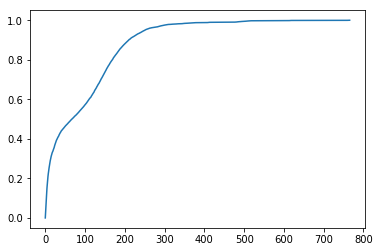

In [93]:
f, ax = plt.subplots()

# Plot the cdf
ax.plot(ack_bins[0:-1], ack_cdf, label="Acks")
ax.plot(chunk_bins[0:-1], chunk_cdf, label="Chunks")
ax.plot(rtt_bins[0:-1], rtt_cdf, label="RTT")

ax.set_xlabel('Time (s)')
ax.set_xlim(0,)
ax.set_ylabel('CDF (%)')
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
ax.set_ylim(0,)
ax.legend()
plt.suptitle('Cumulative distribution function of messages transmission time')


sns.despine()
plt.savefig('outputs/messages_rtt_cdf_n_users.svg')
plt.show()